In [1]:
import utils, r_pca, wtt, wrappers

import os
import numpy as np
import pywt
from skimage.measure import block_reduce

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dirname = 'data'
data_filename = 'monochrome10.npz'

data = np.load(os.path.join(data_dirname, data_filename))

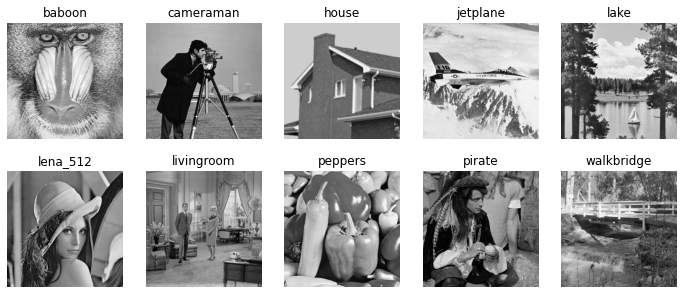

In [3]:
nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12, 5))
cnt = 0
for x in data:
    i, j = cnt // ncols, cnt % ncols
    ax[i, j].imshow(data[x], cmap='gray')
    ax[i, j].set_title(x)
    ax[i, j].set_axis_off()
    cnt += 1
plt.show()

In [4]:
objects = list(data.keys())
dataset = np.array([data[x] for x in objects])

dataset.shape

(10, 512, 512)

In [5]:
original = dataset[1]
original

array([[156, 157, 160, ..., 152, 152, 152],
       [156, 157, 159, ..., 152, 152, 152],
       [158, 157, 156, ..., 152, 152, 152],
       ...,
       [121, 123, 126, ..., 121, 113, 111],
       [121, 123, 126, ..., 121, 113, 111],
       [121, 123, 126, ..., 121, 113, 111]], dtype=uint8)

In [6]:
d = 9
modes = [2] * d
eps = 5e-2
vector, vector_modes = utils.matrix_to_vector(original, d, modes)

In [7]:
lambda_scales = [1., 1.5, 2, 2.5, 3.]

In [8]:
def test_f(
    input_vector,
    d,
    modes,
    ranks=None,
    eps=None,
    lambda_scale=1.0,
):
    
    filters = []
    prod_modes = input_vector.size
    
    assert len(modes) == d
    if ranks is not None:
        assert len(ranks) == d - 1
    if eps is not None:
        assert 0 <= eps <= 1
    assert prod_modes == np.prod(modes)
        
    true_ranks = []
    
    sSize = 0
    sNnz = 0
    usNnz = 0
    
    r_prev = 1
    A = input_vector
    for k in range(d):
        A = A.reshape((r_prev * modes[k], prod_modes // modes[k]), order='F')
        
        #делаем разложение A = L + S, L --- малоранговая, S --- разреженная
        #затем: L = U Sigma V^T --- SVD для L. Ненулевых сингулярных чисел будет мало (надеемся)
        #U^T A = Sigma V^T + U^T S. Старшие строки оставляем для дальнейшей работы.
        #Надеемся, что младшие строки U^T S тоже будут разреженными...
        
        rpca = r_pca.R_pca(A) 
        
        rpca.lmbda = rpca.lmbda * lambda_scale #делаю уклон в сторону sparse'овости
        
        L, S = rpca.fit(
            max_iter=4000,
            iter_print=400,
            verbose=False
        )
        

        
        if A.shape[0] <= A.shape[1]:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=False)
        else:
            u, sigmas, vt = np.linalg.svd(L, full_matrices=True)
            
        sSize += S.size
        sNnz += np.count_nonzero(S)
        usNnz += np.count_nonzero(u.T @ S)
            
        r_given = None if ranks is None else (1 if k == d - 1 else ranks[k])
        r_eps = min(A.shape) if eps is None else max(1, (sigmas > eps * sigmas[0]).sum())
        if r_given is not None:
            r_cur = min(r_given, r_eps)
        else:
            r_cur = r_eps
        
        filters.append(u)
        assert u.shape[0] == u.shape[1] == r_prev * modes[k]
        if k < d - 1:
            assert r_cur <= r_prev * modes[k]

        if k < d - 1:
            A = (u.T @ A)[:r_cur,:]
            #A = (u.T @ (L + S))[:r_cur,:]
            prod_modes //= modes[k]
            true_ranks.append(r_cur)
            r_prev = r_cur
    
    return filters, true_ranks, sSize, sNnz, usNnz

In [9]:
for l in lambda_scales:
    filters, true_ranks, sSize, sNnz, usNnz = test_f(
        vector, d, vector_modes, eps=eps, lambda_scale=l
    )
    
    coeffs = wtt.wtt_apply(vector, d, filters, vector_modes, true_ranks)
    lcn = (np.abs(coeffs) > eps).sum()
    sum_ranks = np.sum(true_ranks)
    
    print(l, sSize, sNnz, usNnz, lcn, sum_ranks)

1.0 393556 57019 122024 244659 15
1.5 393660 31371 73876 244662 20
2 394272 19420 49404 244664 26
2.5 394688 12791 35336 244579 31
3.0 395088 8865 27228 244359 35


In [10]:
coeffs.size

262144

In [17]:
def experiment(
    original_num,
    eps_for_wtt,
    lambda_scale
):
    original = dataset[original_num]
    
    #db_names = ['db2', 'db4', 'db6']
    db_names = []
    dbs = [pywt.Wavelet(name) for name in db_names]
    wtt_classic = wrappers.WTTwrapper(1) #классика
    wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
    wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

    algs = [
        wtt_classic,
        wtt_rpca_1,
        wtt_rpca_2
    ]

    for w in algs:
        w.adjust(
            original,
            d,
            modes,
            eps=eps_for_wtt,
            lambda_scale=lambda_scale,
            is_2D=True
        )

    preproc = wrappers.RPCA_preprocessing_wrapper(2)
    wtt_for_preproc = wrappers.WTTwrapper(1)

    vector, vector_modes = utils.matrix_to_vector(original, d, modes)
    l, s, r = preproc.adjust(
        vector,
        d,
        vector_modes,
        lambda_scale=lambda_scale,
        max_iter=150
    )
    l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

    wtt_for_preproc.adjust(l_matrix, d, modes, ranks=r, eps=eps_for_wtt, is_2D=True)
    algs.append(wtt_for_preproc)

    deltas = np.linspace(1e-2, 1e2, 200)

    CR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset.shape[0])
    ]
    PSNR = [
        [[] for _ in range(len(dbs) + len(algs))] for _ in range(dataset.shape[0])
    ]

    for cnt in range(10):
        original = dataset[cnt]
        coeffs_db = []
        coeffs = []
        for db in dbs:
            coeffs_db.append(pywt.wavedec2(original, db, mode='periodic'))
        for w in algs:
            coeffs.append(w.apply(original, is_2D=True))

        for delta in deltas:
            for i in range(len(dbs)):
                arr, slc = pywt.coeffs_to_array(coeffs_db[i])        
                thresholded = pywt.threshold(arr, delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('dbs, number=', i, 'delta=', delta)
                CR[cnt][i].append(thresholded.size * 1.0 / nnz)

                restored_coeffs = pywt.array_to_coeffs(thresholded, slc, output_format='wavedec2')
                restored = pywt.waverec2(restored_coeffs, dbs[i], mode='periodic')
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('dbs, number=', i, 'delta=', delta)
                    
                restored = np.round(restored)
                restored[restored < 0] = 0
                restored[restored > 255] = 255
                restored = restored.astype(original.dtype)
                    
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][i].append(psnr_value)

            for i in range(len(algs)):
                j = i + len(dbs)
                thresholded = pywt.threshold(coeffs[i], delta, mode='hard')
                nnz = np.count_nonzero(thresholded)
                if nnz == 0:
                    print('div by zero in cr')
                    print('wtts, number =', i, 'delta=', delta)
                CR[cnt][j].append(original.size * 1.0 / nnz)

                restored = algs[i].apply_inverse(thresholded, is_2D=True)
                if nnz == original.size:
                    print('div by zero in psnr')
                    print('wtts, number =', i, 'delta=', delta)
                    
                restored = np.round(restored)
                restored[restored < 0] = 0
                restored[restored > 255] = 255
                restored = restored.astype(original.dtype)    
                
                psnr_value = utils.psnr(original, restored)
                PSNR[cnt][j].append(psnr_value)

    return CR, PSNR

In [18]:
eps = 5e-1
lambda_scale=1.5

In [19]:
orig = 2
CR, PSNR = experiment(orig, eps, lambda_scale)

In [20]:
def plot_results(original_num, CR, PSNR, window=(0,199), logscales=False, shape=None, noisy=False):
    nrows, ncols = 2, 5
    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 9))
    cnt = 0
    db_names = []
    alg_names = db_names + ['classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']
    name = ''
    for x in data:
        if cnt == original_num:
            name = x
        
        c1, c2 = cnt // ncols, cnt % ncols
        for i in range(len(alg_names)):
            #if i in algs_to_plot:
            s = '-' if shape is None else shape[i]
            ax[c1, c2].plot(CR[cnt][i][window[0]:window[1]], PSNR[cnt][i][window[0]:window[1]], s, label=alg_names[i])
        if logscales:
            ax[c1, c2].set_xscale('log')
            ax[c1, c2].set_yscale('log')
        ax[c1, c2].set_title(x)
        ax[c1, c2].grid()
        cnt += 1
    if noisy is True:
        fig.suptitle('Different wavelet transforms; wtt and its variants are trained on noisyfied ' + name, fontsize=16)
    else:
        fig.suptitle('Different wavelet transforms; wtt and its variants are trained on ' + name, fontsize=16)
    fig.text(0.5, 0.04, "Compress Ratio", fontsize=12, color='black', ha='center')
    fig.text(0.04, 0.5, "PSNR", fontsize=12, color='black', va='center', rotation='vertical')
    plt.legend(bbox_to_anchor=(2, 1.2))
    plt.show()

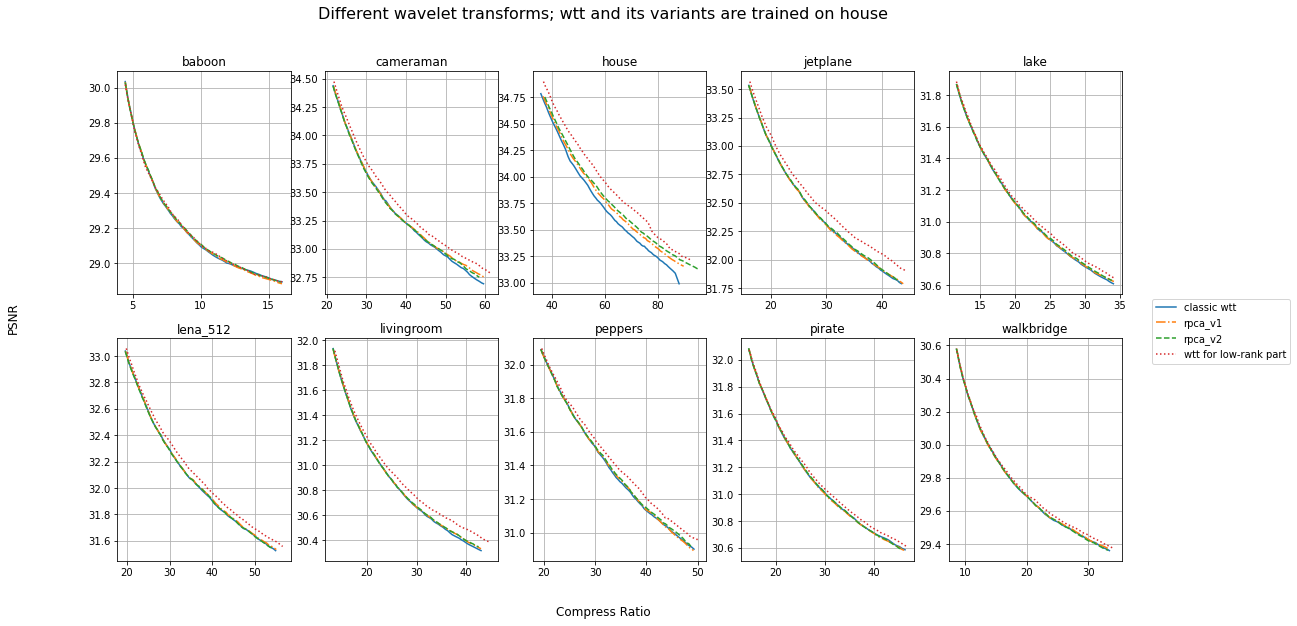

In [23]:
plot_results(orig, CR, PSNR, window=[60, 140], shape=['-','-.','--',':'])

In [69]:
wtt_classic = wrappers.WTTwrapper(1) #классика
wtt_rpca_1 = wrappers.WTTwrapper(2) #просто RPCA вместо SVD
wtt_rpca_2 = wrappers.WTTwrapper(3) #RPCA с сохранением sparse-частей

algs = [
    wtt_classic,
    wtt_rpca_1,
    wtt_rpca_2
]

In [70]:
original = dataset[orig]
to_apply = dataset[3]
imgs_restored = [to_apply]
delta = 40.
for w in algs:
    w.adjust(
        original,
        d,
        modes,
        eps=eps,
        lambda_scale=lambda_scale,
        is_2D=True
    )
    coeffs = w.apply(to_apply, is_2D=True)
    thresholded = pywt.threshold(coeffs, delta, mode='hard')
    restored = w.apply_inverse(thresholded, is_2D=True)
    restored = np.round(restored)
    restored[restored < 0] = 0
    restored[restored > 255] = 255
    restored = restored.astype(original.dtype)
    imgs_restored.append(restored)

In [71]:
preproc = wrappers.RPCA_preprocessing_wrapper(2)
wtt_for_preproc = wrappers.WTTwrapper(1)

vector, vector_modes = utils.matrix_to_vector(original, d, modes)
l, s, r = preproc.adjust(
    vector,
    d,
    vector_modes,
    lambda_scale=lambda_scale,
    max_iter=150
)
l_matrix = utils.vector_to_matrix(l, d, vector_modes)[0]

wtt_for_preproc.adjust(l_matrix, d, modes, ranks=r, eps=eps, is_2D=True)

In [72]:
coeffs = wtt_for_preproc.apply(to_apply, is_2D=True)
thresholded = pywt.threshold(coeffs, delta, mode='hard')
restored = wtt_for_preproc.apply_inverse(thresholded, is_2D=True)
restored = np.round(restored)
restored[restored < 0] = 0
restored[restored > 255] = 255
restored = restored.astype(original.dtype)
imgs_restored.append(restored)

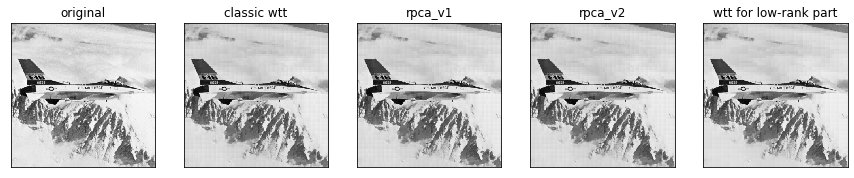

In [73]:
fig = plt.figure(figsize=(15, 3))
data_labels = ['original', 'classic wtt', 'rpca_v1', 'rpca_v2', 'wtt for low-rank part']
for i in range(len(data_labels)):
    ax = fig.add_subplot(1, 5, i + 1)
    ax.imshow(
        imgs_restored[i],
        interpolation="nearest",
        cmap=plt.cm.gray
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(data_labels[i])

In [76]:
for i in range(1, 5):
    print(np.linalg.norm(imgs_restored[0] - imgs_restored[i]))

85263.78896108242
85179.4704315541
85239.35156369973
85009.49389332935
